<a href="https://colab.research.google.com/github/BrendaLoznik/BigBangTheory/blob/main/Bang_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Housekeeping**

### **1.1 Load libraries**

In [83]:
pip install polyglot

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


In [85]:
#run line below to dlownlaod thebdium and large language packages that give errors when you try to import them otherwise
#install --> new runtime --> re-run

In [ ]:
!python -m spacy download en_core_web_md

In [214]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

#toekanization
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from collections import Counter

#preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#gensim
from gensim.corpora.dictionary import Dictionary
from collections import defaultdict
import itertools   
from gensim.models.tfidfmodel import TfidfModel

#spacy
import spacy
nlp = spacy.load('en')
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Span
import random

#polyglot
#from polyglot.text import Text, Word

#ml
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB #works wel with countvectorizer (less well for floats created by tfidf)
from sklearn import metrics

#sentiment
from textblob import TextBlob
from wordcloud import WordCloud


### ***1.2 Load data***

In [88]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**One line per paragraph per episode**

In [89]:
#df: one line per paragraph
df= pd.read_csv('/content/gdrive/MyDrive/Kaggle/Bigbang/cleaned_episodes2.csv', sep = '|')
df.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good idea for a tee-shirt.",3
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5


**Lines by main character per episode**

In [90]:
#df: record for the main characters per episode
episode = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Bigbang/lines_main_characters2.csv')
episode = episode.sort_values(['episode_id', 'character'])
episode.head(2)

episode_id character  \
0        1-1    Howard   
1        1-1   Leonard   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [91]:
#see a little bit more information
pd.set_option('display.max_colwidth', None)

In [92]:
#create a list of the lines of Penny in episode 1 of season 1
penny_series = episode[(episode['episode_id']== '1-1') & (episode['character']=='Penny')]['line']
penny_list = penny_series.tolist()
penny_string = penny_series.to_string(index=False)
penny_string

' Oh, hi! Hi? Oh, that’s nice. Oh, okay, well, guess I’m your new neighbour, Penny. Hi. Hi. Thankyou, maybe we can have coffee sometime. Great. Bye. Hi. Hi. Oh, you’re inviting me over to eat? Oh, that’s so nice, I’d love to. So, what do you guys do for fun around here? Okay, thankyou. This looks like some serious stuff, Leonard, did you do this? Wow. So you’re like, one of those, beautiful mind genius guys. This is really impressive. Holy smokes. Uh, do you guys mind if I start? So, sit next to me. What’s the difference? Do you want me to move? So, Klingon boggle? Um, me, okay, I’m Sagittarius, which probably tells you way more than you need to know. Participate in the what? Oh, yeah, a lot of people think I’m a water sign. Okay, let’s see, what else, oh, I’m a vegetarian, oh, except for fish, and the occasional steak, I love steak. Oh, yeah, I’m a waitress at the Cheesecake Factory. Oh, anyways, I’m also writing a screenplay. It’s about this sensitive girl who comes to L.A. from Linc

# **2 NLP introduction**

### **2.1 Regular expressions**

* \w+: matches word
* \d: matches digit
* \s: matches space
* .*: matches wildcard (any letter or symbol)
* +or* : greedy matches (repeats of letters or patterns)
* \S: matches NOT a space
* [a-z]: matches lowercase group


---

* split: split a string on regex
* findall: find all patterns in a string
* search: search for a pattern: go to entire string and find match 
* match: match an entire string or substring based on pattern: match string from the beginning

In [93]:
#split string on space
pd.set_option('display.max_colwidth', None)
word_list = re.split('\s+', penny_string)
word_list[0:10]

['', 'Oh,', 'hi!', 'Hi?', 'Oh,', 'that’s', 'nice.', 'Oh,', 'okay,', 'well,']

In [94]:
#split on words
word_list = re.findall('\w+', penny_string)
word_list[0:10]

['Oh', 'hi', 'Hi', 'Oh', 'that', 's', 'nice', 'Oh', 'okay', 'well']

In [95]:
#split on sentence

# Write a pattern to match sentence endings: sentence_endings
sentence_endings = r"[.?!]"

word_list = re.split(sentence_endings, penny_string)
word_list[0:5]


[' Oh, hi',
 ' Hi',
 ' Oh, that’s nice',
 ' Oh, okay, well, guess I’m your new neighbour, Penny',
 ' Hi']

In [96]:
#find all captitalized words
capitalized_words = r"[A-Z]\w+"
word_list = re.findall(capitalized_words , penny_string)
word_list[0:10]


['Oh', 'Hi', 'Oh', 'Oh', 'Penny', 'Hi', 'Hi', 'Thankyou', 'Great', 'Bye']

In [97]:
#find all digits in string
digits = r"\d+"
word_list = re.findall(digits , penny_string)
word_list[0:10]


[]

In [98]:
#search for the first occurence of 'Penny' and print the start and end idnexes of the match
match = re.search("Penny", penny_string)
print(match.start(), match.end())

76 81


In [99]:
#search for anything between brackets
pattern1 = r"\(.*\)"
print(re.search(pattern1, penny_string))

<re.Match object; span=(2517, 2566), match='(He just looks at her with a worried expression.)>


In [100]:
#write a pattern to match would match 'Character:" and 'Soldier #1: )
pattern2 = r"[\w\s]+:"
print(re.search(pattern2, penny_string))

None


### **2.2 Tokenization**

* turn a string or document into tokens (smaller chunks)
* e.g. breaking words or sentences, seperating puncuation, all hastags in a tweet
* nltk library is commonly used
* used to match common words, removing unwanted tokens (e.g. repeated words), derrive meaning from text

In [101]:
#tokenize string to sentences
sentences = sent_tokenize(penny_string)
sentences[0:10]

[' Oh, hi!',
 'Hi?',
 'Oh, that’s nice.',
 'Oh, okay, well, guess I’m your new neighbour, Penny.',
 'Hi.',
 'Hi.',
 'Thankyou, maybe we can have coffee sometime.',
 'Great.',
 'Bye.',
 'Hi.']

In [102]:
#tokenize string to words and characters (note the difference)
tokenized_sent = word_tokenize(penny_string)
tokenized_sent[0:10]

['Oh', ',', 'hi', '!', 'Hi', '?', 'Oh', ',', 'that', '’']

In [103]:
#use 'set' to only return the unique items in a list
unique = set(tokenized_sent)
print(unique)

{'let', 'God', 'doesn', 'no', 'is', 'do', 'those', 'my', 'thought', 'mess', 'Hey', 'Can', '.', 're', 'about', 'jerk', 'Until', 'else', 'sorry', 'Great', 'getting', 't', 'lying', 'than', 'going', 'sit', 'everything', 'girl', 'an', 'as', 'trusted', 'though', 'cool', 'No', 'Why', 'some', 'years', 'Do', 'actress', 'crazy', 'okay', 'Okay', 'He', 'coffee', 'Thankyou', 'people', 'ass', 'if', 'went', 'new', 'Hi', 'impressive', 'to', 'd', 's', 'really', 'eat', 'Hello', 'Omaha', 'move', 'except', 'lived', 'used', 'one', 'waitress', 'switch', 'sounds', 'much', 'ideas', 'her', 'also', 'what', 'around', 'cheating', 'mind', 'br/', 'favour', 'think', 'shower', 'don', 'nice', 'Even', 'lot', 'even', 'guess', 'on', 'four', 'moving', 'of', 'speak', 'well', 'water', 'such', 'happened', 'thankyou', 'from', 'trying', 'hi', 'neighbour', '>', 'hate', 'want', 'thing', 'vegetarian', 'comes', 'This', 'Would', 'are', 'know', 'Sheldon', '!', 'guy', 'why', 'yeah', 'probably', 'Is', 'Uh', '(', 'him.', 'anyways', 'gu

**Advanced tokenization with Regex**

In [104]:
#find all digits and words, but no punctuation
match_digits_and_word = ('(\d+ | \w+)')
word_list = re.findall(match_digits_and_word , penny_string)
word_list [0:10]

[' Oh',
 ' hi',
 ' Hi',
 ' Oh',
 ' that',
 ' nice',
 ' Oh',
 ' okay',
 ' well',
 ' guess']

In [105]:
#Define a regex pattern to find hashtags: 
pattern1 = r"#\w+"
hashtags = regexp_tokenize(penny_string, pattern1)  #note how you pass the pattern as the seccond argument
print(hashtags)

[]


In [106]:
#Write a pattern that matches both mentions (@) and hashtags
pattern2 = r"([@|#]\w+)"
mentions_hashtags = regexp_tokenize(penny_string, pattern2)
print(mentions_hashtags)

[]


In [107]:
# Tokenize and print only capital words
capital_words = r"[A-ZÜ]\w+"
print(regexp_tokenize(penny_string, capital_words))

['Oh', 'Hi', 'Oh', 'Oh', 'Penny', 'Hi', 'Hi', 'Thankyou', 'Great', 'Bye', 'Hi', 'Hi', 'Oh', 'Oh', 'So', 'Okay', 'This', 'Leonard', 'Wow', 'So', 'This', 'Holy', 'Uh', 'So', 'What', 'Do', 'So', 'Klingon', 'Um', 'Sagittarius', 'Participate', 'Oh', 'Okay', 'Oh', 'Cheesecake', 'Factory', 'Oh', 'It', 'Lincoln', 'Nebraska', 'Cheesecake', 'Factory', 'No', 'Omaha', 'Okay', 'Um', 'That', 'Penny', 'It', 'Until', 'Oh', 'God', 'High', 'School', 'You', 'Even', 'Is', 'Oh', 'Really', 'Would', 'Thanks', 'You', 'Hey', 'Oh', 'Hi', 'Hello', 'Penny', 'Cheesecake', 'Factory', 'Okay', 'Thanks', 'Hey', 'Leonard', 'Um', 'Can', 'It', 'It', 'So', 'Leonard', 'Sheldon', 'University', 'Uh', 'English', 'Really', 'Wow', 'Uh', 'Oh', 'Oh', 'God', 'Really', 'Why', 'Sure', 'So', 'So', 'Any', 'Raj', 'He', 'That']


#### **Charting with NLTK**

In [108]:
sheldon_series = episode[(episode['episode_id']== '1-1') & (episode['character']=='Sheldon')]['line']
sheldon_string = sheldon_series.to_string(index=False)


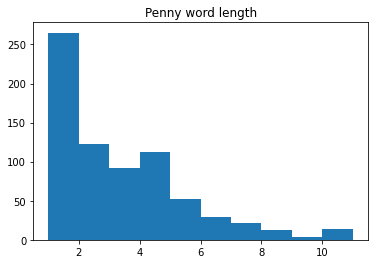

In [109]:
words = word_tokenize(penny_string)
word_lengths = [len(w) for w in words]
plt.hist(word_lengths)
plt.title('Penny word length')
plt.show()

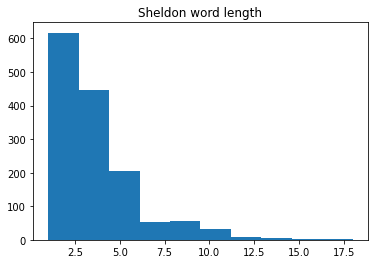

In [110]:
words = word_tokenize(sheldon_string)
word_lengths = [len(w) for w in words]
plt.hist(word_lengths)
plt.title('Sheldon word length')
plt.show()

### **2.3 Topic identification**

* bag of words: finding topics in a text
* create tokens, count them up --> more frequent a word is, the more important it might be
* can help identify significant words in a text

In [111]:
# print 10 most common words

#create token and lowercase it
words = word_tokenize(penny_string)     #use:  re.findall(match_digits_and_word , penny_string)  instead, to exclude punctuation
lower_words = [t.lower() for t in words]

#count the words
word_count = Counter(lower_words)
print(word_count.most_common(10))

[(',', 72), ('.', 50), ('’', 37), ('i', 31), ('?', 25), ('you', 22), ('oh', 15), ('m', 13), ('to', 12), ('so', 12)]


#### **Text preprocessing**

* tokenization to create a bag of words
* lowercasing
* lemmatization (shorten words to their root)
* removing stop owrds, punctuation, or unwanted tokens

In [112]:
#tokenize
words = word_tokenize(penny_string)

#lowercase
lower_words = [t.lower() for t in words]

#only retain alphabetic words
alpha_only = [ w for w in lower_words if w.isalpha()]

#remove stop words
no_stops = [ w for w in alpha_only if w not in stopwords.words('english')]

#lemmatize
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# Create the bag-of-words: bow
bow = Counter(lemmatized)

# Print the 10 most common tokens
print(bow.most_common(10))

[('oh', 15), ('okay', 9), ('hi', 7), ('guy', 7), ('really', 6), ('sorry', 5), ('love', 4), ('like', 4), ('uh', 4), ('know', 4)]


#### **Gensim library**

* popular open-source NLP library
* building document or word vectors
  - multi-dimensional representation of word
  - see relationships among words in a document
  - e.g. Spain is to Madrid as Italiy is to Rome
* performing topic identifciation and document comparison
* Corpus is a set of text used to perform NLP tasks
  - pre-processed text
  - pass tokenized to the Dictionariy class
  - create Gensim corpus (bag of word documents).

In [113]:
# this library needs a list of documents (very basic without any pre-processing)
episode_list_list = episode.copy()

#create a list of each sentence
def preprocessing(text):
     return word_tokenize(text)  #or use sent_tokenize

episode_list_list ['list_of_lines'] = episode_list_list ['line'].apply(preprocessing)

#turn into a list of lists 
#dialogue_list = episode_list_list['list_of_lines'].tolist()

In [114]:
#Pre-process episode so that it can be used in Gensim 
episode_list_list = episode.copy()


#step 1: pre-process the text
episode_list_list['cleaned_text']  = ''

def preprocess (text):
  doc = nlp(text, disable =['ner', 'parser'])
  lemmas = [token.lemma_ for token in doc]
  a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]
  lowercase = [t.lower() for t in a_lemmas]
  no_stops = [w for w in lowercase if w not in stopwords.words('english')]
  return ' '.join(no_stops)

#apply function
episode_list_list['cleaned_text'] =episode_list_list['line'].apply(preprocess)


# this library needs a list of documents: easiest way of doing this is to apply a tokenizer
#create a list of each sentence
def preprocessing(text):
     return word_tokenize(text)  #or use sent_tokenize
#apply function
episode_list_list['list_of_lines'] = episode_list_list['cleaned_text'].apply(preprocessing)

#turn into a list of lists 
dialogue_list = episode_list_list['list_of_lines'].tolist()

episode_list_list.head(2)
#episode_list_list.to_csv('episode_list_of_list.csv') #this is old version


episode_id character  \
0        1-1    Howard   
1        1-1   Leonard   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [115]:
#episode_list_list.to_csv('episode_list_of_list2.csv') 

In [116]:
# Create a Dictionary from the articles
dictionary = Dictionary(dialogue_list)

# Select the id for "computer": computer_id
computer_id = dictionary.token2id.get("computer")
print(dictionary.get(computer_id))


#Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(dialogue) for dialogue in dialogue_list]

# Print the first 10 word ids with their frequency counts from the fifth document
print(corpus[1][:10])

computer
[(1, 1), (2, 2), (5, 1), (6, 1), (14, 2), (30, 4), (31, 9), (32, 7), (33, 1), (34, 5)]


In [117]:
#top 10 words in a given document (document here is a dialogue of one caracter in a given episode)
#here: line of Howard in episode 1

# Save the first document: doc
doc = corpus[0]

# Sort the doc for frequency: bow_doc
bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)

# Print the top 5 words of the document alongside the count
for word_id, word_count in bow_doc[:10]:
    print(dictionary.get(word_id), word_count)

baby 4
back 2
coitus 2
get 2
hang 2
hooked 2
quest 2
see 2
speak 2
yeah 2


In [118]:
#top 10 most common words in entire corpus (= all dialogues)

# Create the defaultdict: total_word_count
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count 
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:10]:
    print(dictionary.get(word_id), word_count)

go 5416
oh 4328
get 4122
know 3965
well 3495
like 2920
would 2639
okay 2586
think 2503
yeah 2372


**TF-IDF with Gensim**

* Tf-idf = term frequency - inverse document frequency
* helps you determine the most importan words in each document in a corpus
* common words should be down-weighted in importance
* ensures that most common words don't show up as key --> keep doucment specific frequent words weighted high


---

* words get low weight if a word occurs often in the document.
* wordts get low weight if it occurs in many of the documents.

* weights can help you determine good topics and key words for a corpus with shared vocabulary. 

In [119]:
episode_list_list.head(6)

episode_id character  \
0        1-1    Howard   
1        1-1   Leonard   
2        1-1     Other   
3        1-1     Penny   
4        1-1       Raj   
5        1-1   Sheldon   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [120]:

# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Save the first document: doc (this is Howard in episode 1)
doc = corpus[0]

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[doc]

# Print the first five weights
print(tfidf_weights[:5])
print()

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(dictionary.get(term_id), weight)

[(0, 0.14099489291881892), (1, 0.13158941696142376), (2, 0.05321396206114465), (3, 0.14766818431112544), (4, 0.09204478815285448)]

hooked 0.28198978583763784
quest 0.22386970721743304
baby 0.20723066953974623
enchante 0.17315242761822225
guay 0.17315242761822225
jow 0.17315242761822225
madamoiselle 0.17315242761822225
tong 0.17315242761822225
coitus 0.1729012206032394
jupiter 0.1570736602685206


### **2.4 Named entity recognition**

* used to identify imortan nemed entities in the text (people, places ,organizatgions, dates, etc.)
* can be used alongisde topic identification
* used to answer who, what, when, where questions


In [121]:
#Named entity recognition (rough, below is nicer)

#tokenize and tag
words = nltk.word_tokenize(penny_string)
tagged_sentence = nltk.pos_tag(words)

#pass tagged sentence in nltk chunk function: returns sentence as a tree
print(nltk.ne_chunk(tagged_sentence[0:20]))

(S
  Oh/UH
  ,/,
  hi/JJ
  !/.
  Hi/NNP
  ?/.
  Oh/UH
  ,/,
  that/IN
  ’/NNP
  s/VBD
  nice/JJ
  ./.
  Oh/UH
  ,/,
  okay/JJ
  ,/,
  well/RB
  ,/,
  guess/NN)


In [122]:
# Tokenize the article into sentences: sentences
sentences = nltk.sent_tokenize(penny_string)

# Tokenize each sentence into words: token_sentences
token_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=True)

# Test for stems of the tree with 'NE' tags
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label") and chunk.label() == "NE":
            print(chunk[0:10])

[('Penny', 'NNP')]
[('Thankyou', 'NNP')]
[('Great', 'NNP')]
[('Bye', 'NNP')]
[('Okay', 'NNP')]
[('Leonard', 'NNP')]
[('Wow', 'NNP')]
[('Holy', 'NNP')]
[('Uh', 'NNP')]
[('Klingon', 'NNP')]
[('Um', 'NNP')]
[('Okay', 'NNP')]
[('Cheesecake', 'NNP'), ('Factory', 'NNP')]
[('Lincoln', 'NNP'), ('Nebraska', 'NNP')]
[('Cheesecake', 'NNP'), ('Factory', 'NNP')]
[('No', 'DT')]
[('Omaha', 'NNP')]
[('Okay', 'NNP')]
[('Um', 'NNP')]
[('Penny', 'NNP')]
[('High', 'JJ'), ('School', 'NNP')]
[('Hi', 'NNP')]
[('Hello', 'NN')]
[('Penny', 'NNP')]
[('Cheesecake', 'NNP'), ('Factory', 'NNP')]
[('Okay', 'NNP')]
[('Hey', 'NNP')]
[('Leonard', 'NNP')]
[('Um', 'NNP')]
[('Leonard', 'NNP')]
[('Sheldon', 'NNP')]
[('University', 'NNP')]
[('Uh', 'NNP')]
[('English', 'NNP')]
[('Wow', 'NNP')]
[('Uh', 'NNP')]


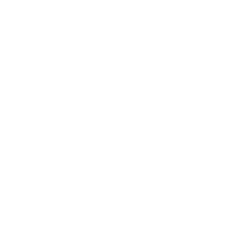

In [123]:
#doesnt work :(

# Create the defaultdict: ner_categories
ner_categories = defaultdict(int)

# Create the nested for loop
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())
labels
# ['ORGANIZATION', 'GPE', 'PERSON', 'LOCATION', 'FACILITY']

# Create a list of the values: values
values = [ner_categories.get(v) for v in labels]

# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

### **2.5 Spacy**

* similar to gensim, but differnt implementations
focus on creating NLP pipelines to generate models and corpora
* uses different entity types compared to nltk
* has informal language corpora (useful for finidng entities in TWeets and chats)

In [124]:

#instantiate the English model
nlp = spacy.load('en')

#create a new document
doc = nlp(penny_string)

#find entities
entities = doc.ents
entities[0:10]

(Penny,
 Leonard,
 one,
 Klingon,
 the Cheesecake Factory,
 L.A.,
 Lincoln Nebraska,
 the Cheesecake Factory,
 Omaha,
 Penny)

In [125]:
#print the label of the first entity
print(doc.ents[0], doc.ents[0].label_)
print()

# Print all of the found entities and their labels
for ent in doc.ents:
    print(ent.label_, ent.text)


Penny PERSON

PERSON Penny
PERSON Leonard
CARDINAL one
GPE Klingon
FAC the Cheesecake Factory
GPE L.A.
ORG Lincoln Nebraska
FAC the Cheesecake Factory
GPE Omaha
PERSON Penny
DATE four years
DATE four years
PERSON Penny
FAC the Cheesecake Factory
PERSON Leonard
PERSON Leonard
PERSON Sheldon
LANGUAGE English
PERSON Raj


**Polyglot (multilingual)**

* NLP library which uses word verctors (like Gensim and Spacy)
* Polyglot supports more than 130 languages, so it is useful for translating texts.

### **2.5 Modelling with NLP**

In [126]:
df.head()

,episode_nr,season,season_episode,episode_id,episode_name,character,location,line,line_id
0,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.",1
1,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,"Agreed, what’s your point?",2
2,1,1,1,1-1,Pilot Episode,Sheldon,A corridor at a sperm bank.,"There’s no point, I just think it’s a good idea for a tee-shirt.",3
3,1,1,1,1-1,Pilot Episode,Leonard,A corridor at a sperm bank.,Excuse me?,4
4,1,1,1,1-1,Pilot Episode,Receptionist,A corridor at a sperm bank.,Hang on.,5


In [127]:
#BAG OF WORDS (text is not pre-processed)
#create a copy of the dataset, drop empty records, and only include the 4 main characters
df2 = df.copy()
df2 = df2.dropna()

mains = ['Sheldon',  'Penny']
df2 = df2[df2['character'].isin(mains)]

#define labels
y = df2['character']
X = df2['line']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#create count vectorizer (similar to gensim corpus) = bag of words + remove stop words
count_vectorizer = CountVectorizer(stop_words='english')

#transform training data to create bag of words
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

# Print the first 10 features of the count_vectorizer (??!)
print(count_vectorizer.get_feature_names_out()[:10])

#fit model
#Naive BAyes is often used for NLP classification because of its'basis in probability
# given a particular piece of data, how likely is a particular?
# how likely given a spaceship, how likely is the series to be sci-fi?
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)

#evaluate
metrics.accuracy_score(y_test, pred)

['000' '000lb' '01100111' '0400' '06' '0700' '10' '100' '101' '102']


0.7272101823185414

In [128]:
#TFIDF (text is not pre-processed)
#create a copy of the dataset, drop empty records, and only include the 4 main characters
df2 = df.copy()
df2 = df2.dropna()

mains = ['Sheldon', 'Penny']
df2 = df2[df2['character'].isin(mains)]

#define labels
y = df2['character']
X = df2['line']

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names_out()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

#fit model
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train , y_train)
pred = nb_classifier.predict(tfidf_test)

#evaluate
metrics.accuracy_score(y_test, pred)


['000' '000lb' '01100111' '0400' '06' '0700' '10' '100' '101' '102']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


0.7291021671826625

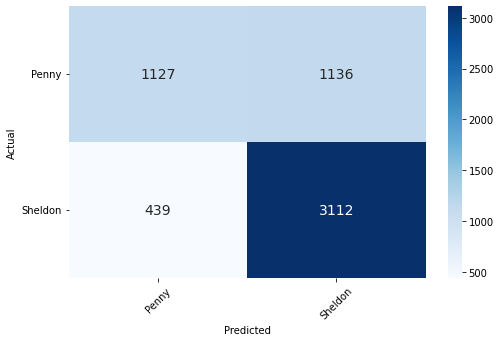

In [129]:
#plot confusion matrix
def confusion_matrix_plotter (y_test,y_pred):
  fig, ax = plt.subplots(figsize=(8,5)) 
  data = metrics.confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
  ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
  ax.set_xlabel("Predicted")
  ax.set_ylabel ("Actual")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

confusion_matrix_plotter(y_test, pred)

In [130]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries (makes little sense without cleaning the data)
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])


Penny [(-10.329157073625595, '0400'), (-10.329157073625595, '11th'), (-10.329157073625595, '150'), (-10.329157073625595, '1619'), (-10.329157073625595, '1865'), (-10.329157073625595, '1am'), (-10.329157073625595, '20s'), (-10.329157073625595, '22'), (-10.329157073625595, '2a'), (-10.329157073625595, '30s'), (-10.329157073625595, '34'), (-10.329157073625595, '390'), (-10.329157073625595, '401k'), (-10.329157073625595, '58'), (-10.329157073625595, 'aaaaaaa'), (-10.329157073625595, 'abducted'), (-10.329157073625595, 'abs'), (-10.329157073625595, 'accents'), (-10.329157073625595, 'acne'), (-10.329157073625595, 'acoustics')]
Sheldon [(-6.214702697173658, 'say'), (-6.136435490956541, 've'), (-6.108977547406329, 'thank'), (-6.080420122995037, 'want'), (-5.999194762273916, 'hello'), (-5.955587329340971, 'think'), (-5.945461906566187, 'did'), (-5.944211569208797, 'll'), (-5.938849416489132, 'good'), (-5.915301303890037, 'penny'), (-5.892947722135722, 'knock'), (-5.834718258817, 'just'), (-5.821

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


# **3  NLP Advanced - Spacy**

* core is the language specific nlp object
* contains the processing pipeline, including language-specific rules for tokenization
* the nlp object produces a doc object, which you can use to access information
* a doc consists of tokens, which can be words and punctuation

### **3.1 Finding words, phrases, names**

In [131]:
#instantiate the English model
nlp = spacy.load('en')

#create a new document
doc = nlp(penny_string)
print(doc.text)
print()

#available token attributes in doc
print('Index', [token.i for token in doc]) #index of token within doc
print('Text', [token.text for token in doc]) #returns the text
print('is_alpha', [token.is_alpha for token in doc]) 
print('is_punct', [token.is_punct for token in doc]) 
print('is_num', [token.like_num for token in doc]) 


 Oh, hi! Hi? Oh, that’s nice. Oh, okay, well, guess I’m your new neighbour, Penny. Hi. Hi. Thankyou, maybe we can have coffee sometime. Great. Bye. Hi. Hi. Oh, you’re inviting me over to eat? Oh, that’s so nice, I’d love to. So, what do you guys do for fun around here? Okay, thankyou. This looks like some serious stuff, Leonard, did you do this? Wow. So you’re like, one of those, beautiful mind genius guys. This is really impressive. Holy smokes. Uh, do you guys mind if I start? So, sit next to me. What’s the difference? Do you want me to move? So, Klingon boggle? Um, me, okay, I’m Sagittarius, which probably tells you way more than you need to know. Participate in the what? Oh, yeah, a lot of people think I’m a water sign. Okay, let’s see, what else, oh, I’m a vegetarian, oh, except for fish, and the occasional steak, I love steak. Oh, yeah, I’m a waitress at the Cheesecake Factory. Oh, anyways, I’m also writing a screenplay. It’s about this sensitive girl who comes to L.A. from Linco

In [132]:
#you can use indexing on the doc to return only part of the doc

nlp = spacy.load('en')
doc = nlp(penny_string)

#print first token
first_token = doc[1] #actual first token is an empty string
print(first_token.text)
token_range = doc[1:7] #actual first token is an empty string
print(token_range)

Oh
Oh, hi! Hi?


In [133]:
#find texts in string using token attributes
doc = nlp("In 1990, more than 60% of people in East Asia were in extreme poverty. Now less than 4% are.")

# Iterate over the tokens in the doc
for token in doc:
    # Check if the token resembles a number
    if token.like_num:
        # Get the next token in the document
        next_token = doc[token.i + 1]
        # Check if the next token's text equals '%'
        if next_token.text == '%':
          print('Percentage found:', token.text)

Percentage found: 60
Percentage found: 4


### **3.2 Spacy - Part of speech tags**

* enable Spacy to predict linguistic attributes (e.g. is it a name)
* these models are trained on large labeled example texts, but can be updated with more examples to fine_tune it's predictions
* Spacy has multiple model packages that you can download
-- 'en_core_web_sm is small english models that is trained on web tests
-- the package contains the binary weights that Spacy needs to make a prediction, vocabulary and meta information.

In [134]:
#use spacy's statistical models to predict the label of words

nlp = spacy.load('en_core_web_sm')
doc = nlp(penny_string)

#only look at first 10 words
short_tokens = doc[0:10]

for token in short_tokens:
  print(token.text, token.pos_) # return each token and the part-of-speech tag

  SPACE
Oh INTJ
, PUNCT
hi INTJ
! PUNCT
Hi INTJ
? PUNCT
Oh INTJ
, PUNCT
that DET


In [135]:
#you can also predict how words are related (e.g. are they the subject of the sentence)
# head attribute returns the syntactic head token (the parent token the token is attached to)

doc = nlp(penny_string)
short_tokens = doc[0:10]

for token in short_tokens:
  print(token.text, token.pos_, token.dep_, token.head.text) # return each token and the part-of-speech tag

  SPACE  Oh
Oh INTJ intj hi
, PUNCT punct hi
hi INTJ ROOT hi
! PUNCT punct hi
Hi INTJ ROOT Hi
? PUNCT punct Hi
Oh INTJ intj that
, PUNCT punct Oh
that DET ROOT that


In [136]:
#and for named entities

for ent in doc.ents:
  #print(ent.text, ent.label_)
  ent_text = ent.text
  ent_label = ent.label_
  print('{:<30}{:<10}'.format(ent_text, ent_label))


Penny                         PERSON    
Leonard                       PERSON    
one                           CARDINAL  
Klingon                       GPE       
the Cheesecake Factory        FAC       
L.A.                          GPE       
Lincoln Nebraska              ORG       
the Cheesecake Factory        FAC       
Omaha                         GPE       
Penny                         PERSON    
four years                    DATE      
four years                    DATE      
Penny                         PERSON    
the Cheesecake Factory        FAC       
Leonard                       PERSON    
Leonard                       PERSON    
Sheldon                       PERSON    
English                       LANGUAGE  
Raj                           PERSON    


In [137]:
#quickly check what a label means
spacy.explain('GPE')

'Countries, cities, states'

* PERSON:      People, including fictional.
* NORP:        Nationalities or religious or political groups.
* FAC:         Buildings, airports, highways, bridges, etc.
* ORG:         Companies, agencies, institutions, etc.
* GPE:         Countries, cities, states.
* LOC:         Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
* EVENT:       Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART: Titles of books, songs, etc.
* LAW:         Named documents made into laws.
* LANGUAGE:    Any named language.
* DATE:        Absolute or relative dates or periods.
* TIME:        Times smaller than a day.
* PERCENT:     Percentage, including ”%“.
* MONEY:       Monetary values, including unit.
* QUANTITY:    Measurements, as of weight or distance.
* ORDINAL:     “first”, “second”, etc.
* CARDINAL:    Numerals that do not fall under another type.

### 3.3 Spacy matcher

* write rules to find words and phrases in text
* comppared to regular expressions, spacy works with doc objects, not just strings. It is also more flexible.
* you can also find words using the model's predictions (e.g. the noun 'duck' vs. the verb 'duck')


---
* match patterns are a list of dictionaries, one item per token.
** {'ORTH': 'iPhone'} is an exact match for iPhone
** {'LOWER': 'iphone'} matches lowercase form of iphone
** {'LEMMA': 'buy'} matches items that contain the lemmatized version of buy 
** pattern = [{'TEXT': 'iOS'}, {'IS_DIGIT': True}] (("iOS 7", "iOS 11", "iOS 10"))
** Write a pattern that matches a form of "download" plus proper noun
pattern = [{'LEMMA': 'download'}, {'POS': 'PROPN'}]
** Write a pattern for adjective plus one or two nouns
pattern = [{'POS': 'ADJ'}, {'POS': 'NOUN'}, {'POS': 'NOUN', 'OP': '?'}]



In [138]:
#load model and create the nlp object
nlp = spacy.load('en_core_web_sm')
doc = nlp(penny_string)

#initialize the matcher with shared vocabulary
matcher = Matcher(nlp.vocab)

#add a pattern to the matcher
pattern = [{'LEMMA': 'speak'}, {'TEXT': 'English'}] 
matcher.add('Speak_pattern', None, pattern)  #second argument is an optinal callbakc

#call matches on doc
matches = matcher(doc)  #returns tuple with match:id, start_index and end index
print(matches)

print('Total matches found:', len(matches))
print('Matches:', [doc[start:end].text for match_id, start, end in matches])

[(8309639128054061621, 551, 553)]
Total matches found: 1
Matches: ['speak English']


In [139]:
pattern = [{'LEMMA': 'love', 'POS': 'VERB'}, { 'POS': 'NOUN', 'OP': '?'}] #OPerator  is added to indicate to match 0 or 1 times, but more is possible
matcher.add('love_pattern', None, pattern)  #second argument is an optinal callbakc
matches = matcher(doc) 
print(matches)

print('Matches:', [doc[start:end].text for match_id, start, end in matches])

[(9434855986025066383, 68, 69), (9434855986025066383, 229, 230), (9434855986025066383, 229, 231), (9434855986025066383, 388, 389), (8309639128054061621, 551, 553)]
Matches: ['love', 'love', 'love steak', 'love', 'speak English']


In [140]:
#load model and create the nlp object
nlp = spacy.load('en_core_web_sm')
doc = nlp(penny_string)

#initialize the matcher with shared vocabulary
matcher = Matcher(nlp.vocab)

#add a pattern to the matcher
pattern = [{'POS': 'ADJ'}, {'POS': 'NOUN'}, {'POS': 'NOUN', 'OP': '?'}]
matcher.add('newpattern', None, pattern)  #second argument is an optinal callbakc

#call matches on doc
matches = matcher(doc)  #returns tuple with match:id, start_index and end index
#print(matches)

print('Total matches found:', len(matches))
print('Matches:', [doc[start:end].text for match_id, start, end in matches])


Total matches found: 10
Matches: ['new neighbour', 'serious stuff', 'beautiful mind', 'beautiful mind genius', 'occasional steak', 'sensitive girl', 'pathetic part', 'stupid shower', 'cool tiger', 'worried expression']


### 3.4 Spacy under the hood

* vocab: stores data across multiple documents
* all strings are stored to hash values (a word is stored only once)
* strings are stored once in the stringstore
* lexemes are context-independent entries in the vocabulary 



---


* a doc contains words in context (e.g. I love coffee), with their part of speech tegs and dependencies
* each token refers to a lexeme, which knows the words hash id (e.g. love = 37020...)
* to get the string representation of the word, the has can be looked up in the strongstore


---

**tips**
* convert the doc as late as possible because f you do it early, you loose all relationships between the tokens.

In [141]:
#each word is saved using a hash

#load model and create the nlp object
nlp = spacy.load('en_core_web_sm')
doc = nlp(penny_string)

# Look up the hash for the word "hello"
hello_hash = nlp.vocab.strings['hello']
print(hello_hash)

# Look up the hello_hash to get the string
hello_string = nlp.vocab.strings[hello_hash]
print(hello_string)

print()
lexeme = nlp.vocab['hello']
print (lexeme.text, lexeme.orth, lexeme.is_alpha)

5983625672228268878
hello

hello 5983625672228268878 True


### 3.5 Semantic similarity

* compare two objects and predict how similarity they are (docs, spans or token)
* similarity is expressed in a scale of 0 to 1
* you need a model that has word vectors included, such as a medium or large model
* if you want to use word vectors, always use the medium or large models, not the small model
----
* similarity is determined using word vectors (multi-demensional meaning representations of words)
* generated using an algorithm that is similar to the Word2Vec that is often used to create wordvectors
* doc and span ectors deffault to the average of token vectors, that is why short phrases are better than long documents with many irrelevant words
* similarity can be used for many applications: recommendation systems, flagging duplicates etc.
* there is no objective definition of similarity ('I like cats' and 'I hate cats' have a high similarity score, becuase they both express sentiment about cats, but there are contexts where you may want them to be very dissimilar

In [142]:
#load a model with vectors
nlp = spacy.load('en_core_web_md')

#create a string for sheldon
sheldon_series = episode[(episode['episode_id']== '1-1') & (episode['character']=='Sheldon')]['line']
sheldon_string = sheldon_series.to_string(index=False)

#create two documetns and create how similar they are
doc1 = nlp(penny_string)
doc2 = nlp(sheldon_string)
print(doc1.similarity(doc2))

0.9754445545646069


In [143]:
#compare two docs - similarity is very objective
doc1 = nlp("I like cats")
doc2 = nlp ("I hate cats")
doc3 = nlp ('I like dogs')

#print vector of the word 'I'
i_vector = doc1[0].vector
#print(i_vector)
print()

#print documents
print(doc1.similarity(doc2))
print(doc1.similarity(doc3))


0.9501447503553421
0.957709143352323


### 3.6 Combining statistical models and rules

**Statistical models**
* applications that need to generalize based on examples
* used for product names, person names, object relatonships
* part-of-speech tagger, entity recognizer, dependency parser are some of the spacy features



---
**Rule-based systems**
* handy where there is a finite number of examples you may want to find
* e.g. countries f the world, cities, drug names, dog breeds
* tokenizer, Matcher, PhraseMatcher as some of the examples here


In [144]:
#example of phrase matching

#initailze phrasematcher with a vocabulary
matcher = PhraseMatcher(nlp.vocab)

#pass in a doc object as the pattern
pattern = nlp('I’m')
matcher.add('IAM', None, pattern)

doc = nlp(penny_string)

#iterate over the matches
for match_id, start, end in matcher(doc):
  #get the matched span
  span = doc[start:end]
  print('Matched span:', span.text)



Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m
Matched span: I’m


In [145]:
#this is how you could match with matcher

doc = nlp(penny_string)

# Create the match patterns
#pattern1 = [{'LOWER': 'amazon'}, {'IS_TITLE': True, 'POS': 'PROPN'}]
#pattern2 = [{'LOWER': 'ad'}, {'TEXT': '-'}, {'LOWER': 'free'}, {'POS': 'NOUN'}]

pattern1 = [{'LEMMA': 'speak'}, {'TEXT': 'English'}] 
pattern2 = [{'LEMMA': 'love'}, { 'POS': 'NOUN'}] 

# Initialize the Matcher and add the patterns
matcher = Matcher(nlp.vocab)
matcher.add('PATTERN1', None, pattern1)
matcher.add('PATTERN2', None, pattern2)

# Iterate over the matches
for match_id, start, end in matcher(doc):
  # Print pattern string name and text of matched span
  print(doc.vocab.strings[match_id], doc[start:end].text)

PATTERN2 love steak
PATTERN1 speak English


In [146]:
#this is how you use phrase matcher

doc = nlp(penny_string)

# Import the PhraseMatcher and initialize it
matcher = PhraseMatcher(nlp.vocab)

# Create pattern Doc objects and add them to the matcher
# This is the faster version of: [nlp(name) for name in names]
names = ['Penny', 'Sheldon', 'Leonard', 'Howard']  #phase matcher is useful when you have a finite list
patterns = list(nlp.pipe(names ))
matcher.add('NAME', None, *patterns)

# Call the matcher on the test document and print the result
matches = matcher(doc)
print([doc[start:end] for match_id, start, end in matches])

[Penny, Leonard, Penny, Penny, Leonard, Leonard, Sheldon]


In [147]:
#above we used phraseMatcher to fines names in a text
# you can run phrasematcher on a longer text, analyze the syntax, and update the document's entities with the matched countries

# Iterate over the matches
for match_id, start, end in matcher(doc):
    # Create a Span with the label for "PERSON   #the current matches are already classifier as persons, but if they werent, you could give them the right tag
    span = Span(doc, start, end, label='PERSON')

    # Overwrite the doc.ents and add the span
    #doc.ents = list(doc.ents) + [span]

    # Get the span's root head token
    span_root_head = span.root.head
    # Print the text of the span root's head token and the span text
    print(span_root_head.text, '-->', span.text)
    
# Print the entities in the document
#print([(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'PERSON'])


neighbour --> Penny
do --> Leonard
of --> Penny
Penny --> Penny
Hey --> Leonard
with --> Leonard
Leonard --> Sheldon


### **3.7 Processing pipelines**

* what happens when you call nlp on text?
** tokenizer to turn text in doc opject
** tagger: part of speech tagger
** parser: adds token.head, token.dep etc.
** ner: named entity recornizer 
** textcat: text classifier
** result is the doc object

* the spacy models contain the language, the pipeline components used by the model (e.g. tagger, parser, ner)



---

**custom pipeline components**

* e.g. add your own metadeta to document ansd tokens
** update built-in attributes like doc.ents
** not for updating the pre-trained models and improving their predictions



--




In [148]:
# Load the en_core_web_sm model
nlp = spacy.load('en_core_web_sm')

# Print the names of the pipeline components
print(nlp.pipe_names)

# Print the full pipeline of (name, component) tuples
print(nlp.pipeline)

['tagger', 'parser', 'ner']
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fce374dcc10>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fce2ecbca60>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7fce11c1b600>)]


In [149]:
#custom pipeline components

#create nlp object
nlp = spacy.load('en_core_web_sm')

#define a custom components
def custom_components(doc):
  print(len(doc))
  doc_length = len(doc)
  print("This document is {} tokens long.".format(doc_length))
  return doc

# add component first in the pipeline
nlp.add_pipe(custom_components, first=True)

#print pipeline components names
print('Pipeline', nlp.pipe_names)

#process text
doc = nlp("Hello world!")

Pipeline ['custom_components', 'tagger', 'parser', 'ner']
3
This document is 3 tokens long.


In [150]:
#complex components


# Import the PhraseMatcher and initialize it
matcher = PhraseMatcher(nlp.vocab)
names = ['dog', 'cat', 'horse', 'fish', 'Sagittarius']  #phase matcher is useful when you have a finite list
patterns = list(nlp.pipe(names ))
matcher.add('ANIMAL', None, *patterns)


# Define the custom component that finds animal names in the document and adds the matched spands to the doc.ents
def animal_component(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label 'ANIMAL'
    spans = [Span(doc, start, end, label='ANIMAL')
             for match_id, start, end in matches]
    # Overwrite the doc.ents with the matched spans
    doc.ents = spans
    return doc

# Add the component to the pipeline after the 'ner' component 
nlp.add_pipe(animal_component, after='ner')
print(nlp.pipe_names)

# Process the text and print the text and label for the doc.ents
doc = nlp("I have a cat and a Golden Retriever")
print([(ent.text, ent.label_) for ent in doc.ents])

1
This document is 1 tokens long.
1
This document is 1 tokens long.
1
This document is 1 tokens long.
1
This document is 1 tokens long.
1
This document is 1 tokens long.
['custom_components', 'tagger', 'parser', 'ner', 'animal_component']
8
This document is 8 tokens long.
[('cat', 'ANIMAL')]


In [153]:
# you could potentially use this to re-label the word 'saggitatirus' as animal
doc = nlp(penny_string)

print([(ent.text, ent.label_) for ent in doc.ents])

684
This document is 684 tokens long.
[('Sagittarius', 'ANIMAL'), ('fish', 'ANIMAL')]


### 3.8 Processing large volumes of text

* nlp.pipe processes texts as a stream and yields doc objects
* much faster than calling nlp on each text

In [165]:
#spacy requires a list of strings
episode_list_list = episode.copy()

#step 1: pre-process the text
episode_list_list['cleaned_text']  = ''

#create nlp object
nlp = spacy.load('en_core_web_sm')

def preprocess (text):
  doc = nlp(text, disable =['ner', 'parser'])
  lemmas = [token.lemma_ for token in doc]
  a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]
  lowercase = [t.lower() for t in a_lemmas]
  no_stops = [w for w in lowercase if w not in stopwords.words('english')]
  return ' '.join(no_stops)

#apply function
episode_list_list['cleaned_text'] =episode_list_list['line'].apply(preprocess)

#create a list of strings
dialogue_list = episode_list_list['cleaned_text'].tolist()


In [166]:

dialogue_list [0:5]

['wait till see stephen hawking lecture mit become creepy computer voice yeah right grandmother back town hang really lady want anticipate coitus available coitus enchante madamoiselle howard wolowitz cal tech department applied physics may familiar work currently orbit jupiter large moon take high resolution digital photograph bon douche french good shower sentiment express six language see ka tong guay jow oh speak english speak woman kind nerd juice box one favourite place kick back quest great house ale yeah since level ten name button anyway game character could hang maybe go quest think turn leave lake street head colorado know wonderful little sushi bar karaoke baby baby get hooked uh baby baby get hooked',
 'agree point excuse one across aegean eight nabakov twenty six across mcm fourteen move finger phylum make fourteen across port au prince see papa doc capital idea port au prince haiti yes um high iq sperm bank thank right back kid semi pro sheldon idea little extra money ge

In [170]:
# use nlp/pipe to process a list of text

# Process the texts and print the adjectives
for text in dialogue_list:
    doc = nlp(text)
    #print([token.text for token in doc if token.pos_ == 'ADJ'])
    #this returns a list of adjectives
    #['available', 'familiar', 'large', 'high', 'french', 'good', 'favourite', 'wonderful', 'little']
    #['high', 'little', 'extra', 'fractional', 'bandwidth', 'new', 'significant', 'old', 'separate'....]

# Process the texts and print the entities
docs = list(nlp.pipe(dialogue_list))
entities = [doc.ents for doc in docs]
print(*entities[0:10])

## Create a list of patterns for the PhraseMatcher
people = ['bert', 'stuart', 'lady gaga', 'stephen hawking']
patterns = list(nlp.pipe(people))

(stephen hawking, mit, coitus, coitus, tech department, jupiter, douche french, six, english, one, ten, lake street, colorado) (eight nabakov, twenty six, fourteen, fourteen, papa doc capital, two, two, one, indian, one, welcome board like board board, twenty six, klingon, sheldon try, sagittarius, first, wu, albert einstein, thanksgiving, turkey, luke skywalker, coitus, coitus, favour sheldon, joyce kim, two, may day, one day, nobel prize, thai) (hang help,) (neighbour penny, one, klingon, vegetarian, lincoln, nebraska, cheesecake factory omaha, four year, four year, tub shower, english, raj) () (photon direct plane two, two, twelve, two hundred pound, two, today, quantum, mit, winter, summer, tuesday, night, klingon, one morning, four year, luke skywalker, coitus, half, penis, russian, arabic, farsi, joyce kim, north korea, two, first, nobel prize, imaginary thai, indian, mack) (farminfarmian, bogarde symposium quark, evening) (miles dyson, dyson, skynet kinky, sheldon, bin, sheldon,

### **3.9 Training a Spacy model**

* why update the model: make model more accurate by showing it examles to your domain... very useful for entity recognition
* examples need to  come with context (e.g. 'iphone X is coming' but text witout entities are also important ( 'i need a new phone, any tips?')
* to update an existing model, you can start with a few hundred to a few thoustand training examples. For a new category you need up to a million examples.
* also include examples that the model previously predicted correctly because otherwise it might unlearn it

In [ ]:
#creating training data

# Two tokens whose lowercase forms match 'iphone' and 'x'
#pattern1 = [{'LOWER': 'iphone'}, {'LOWER': 'x'}]
pattern1 = [{'LEMMA': 'speak'}, {'TEXT': 'English'}] 

# Token whose lowercase form matches 'iphone' and an optional digit
#pattern2 = [{'LOWER': 'iphone'}, {'IS_DIGIT': True, 'OP': '?'}]
pattern2 = [{'LEMMA': 'love'}, { 'POS': 'NOUN'}] 

# Add patterns to the matcher
# Initialize the Matcher and add the patterns
matcher = Matcher(nlp.vocab)
#matcher.add('PATTERN1', None, pattern1)
#matcher.add('PATTERN2', None, pattern2)
matcher.add('GADGET', None, pattern1, pattern2)  #gives an error but should work
 
# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(dialogue_list):
    # Find the matches in the doc
    matches = matcher(doc)
    
    # Get a list of (start, end, label) tuples of matches in the text
    entities = [(start, end, 'GADGET') for match_id, start, end in matches]
    print(doc.text, entities) 

#create training data
TRAINING_DATA = []

# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(dialogue_list):
    # Match on the doc and create a list of matched spans
    spans = [doc[start:end] for match_id, start, end in matcher(doc)]
    # Get (start character, end character, label) tuples of matches
    entities = [(span.start_char, span.end_char, 'GADGET') for span in spans]
    
    # Format the matches as a (doc.text, entities) tuple
    training_example = (doc.text, {'entities': entities})
    # Append the example to the training data
    TRAINING_DATA.append(training_example)
    
#print(*TRAINING_DATA, sep='\n')    

In [ ]:
#train the model
for i in range (10):
  #shuffle the training data
  random.shuffle(TRAINING_DATA)
  #create batches and iterate over tehm
  for batch in spacy.util.minibatch(TRAINING_DATA):
    #split the batch in texts and annotations
    texts = [text for text, annotation in batch]
    annotations = [annotation for text, annotation in batch]
   #update the mode
    #nlp.update(texts, annotations)
#save the model
#nlp.to_disk(path_to_model)

In [185]:
#setting up new pipeline from scratch

# Create a blank 'en' model
nlp = spacy.blank('en')

# Create a new entity recognizer and add it to the pipeline
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

# Add the label 'GADGET' to the entity recognizer
ner.add_label('GADGET')

# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in range(10):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}
    
    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=2):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]
        
        # Update the model
        #nlp.update(texts, annotations, losses=losses)
        ##print(losses) #The numbers printed to the IPython shell represent the loss on each iteration, the amount of work left for the optimizer. 

# **4 Sentiment analysis**

### 4.1 Rule vs machine sentiment

* the process of understanding the opintion of an author about a subject.
* three elements: 
-- opinion/emotions (positive, negative, joy, mad)
-- subject of discussion (movie, product)
-- opinion holder(entity) 

* used for social media monitoring (how do peeople talk about brand), customer service, product analytics, market research etc.



---
**levels of granularity**

* document level (entire reivew)
* sentence level
* aspect level (different features of a single of a product)


---



**types of sentiment analysis algorithms**
* *rule/lexicon-based*
** predefined list of words with balance score (nice: +2, good: +1) --> model sums/averages the scores of each word for total balance (valence)
** rely on manually crafted valance scores
** fail at certain tasks because polarity of word can change with the context of the words
** quite fast
* *automated/machine leanring systems*
** requires having labelled historical data
** take a while to train
** powerful


In [194]:
#how many word has the longest dialogue
print( max( df['line'].str.len()))
print( min( df['line'].str.len()))

1071
1


In [213]:
#what is the valance (balance) of a sentence?

#apply textblob object (contains some NLP processing )
#polarity (positivity) is measured on scale of -1 to 1 
#subjectivity is measured on scale of 0 to 1, where 0 is very objective (factual) and 1 very subjectiive (personal opinion)
penny_blob= TextBlob(penny_string)
print("Sentiment of Penny:", penny_blob.sentiment )
print()

sheldon_blob = TextBlob(sheldon_string)
print("Sentiment of Sheldon:", sheldon_blob.sentiment )



Sentiment of Penny: Sentiment(polarity=0.1693345901410417, subjectivity=0.5856583112228274)

Sentiment of Sheldon: Sentiment(polarity=0.11662585034013603, subjectivity=0.46127834467120193)


### 4.2 word cloud

** more common words are displayed bolder
* pro: review essential, provide an overal sense of the text, easy to understan
* downlside: can be confusing, large texts require pre-processing

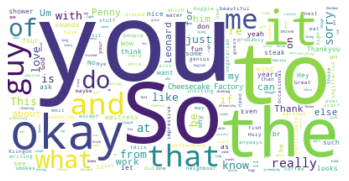

In [218]:
#create wordcloud:  type ?WordCloud for more arguments to add to the cloud function

my_stopwords = ['uh', 'oh', 'hi']
cloud_penny = WordCloud(background_color="white", stopwords=my_stopwords).generate(penny_string)  

#display
plt.imshow(cloud_penny, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### 4.3 Bag of words